# California Bike Sharing

In [1]:
%load_ext autoreload
%autoreload 2}

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

from matplotlib import cm

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

from macest.regression import models as reg_mod
from macest.regression import plots as reg_plot
from macest.model_selection import KFoldConfidenceSplit


In [3]:
sns.set_style('darkgrid')
sns.set_context('notebook')

## Load (cleaned and pre-processed) data  

In [4]:
bike_df = pd.read_csv('../../data/bike_df.csv').sample(frac=1)
bike_df.reset_index(drop=True, inplace=True)
y = bike_df['cnt'].values
X = bike_df.drop('cnt', axis =1).values

## Split the data into 4 groups

In [5]:
X_pp_train, X_conf_train, y_pp_train, y_conf_train  = train_test_split(X,
                                                                       y,
                                                                       test_size=0.66,
                                                                       random_state=10)

X_conf_train, X_cal, y_conf_train, y_cal = train_test_split(X_conf_train, y_conf_train,
                                                            test_size=0.5, random_state=1)
X_cal, X_test, y_cal,  y_test, =  train_test_split(X_cal, y_cal, test_size=0.5, random_state=1)

In [6]:
bike_df.shape

(17379, 14)

In [7]:
print(X_pp_train.shape)
print(X_conf_train.shape)
print(X_cal.shape)
print(X_test.shape)

(5908, 13)
(5735, 13)
(2868, 13)
(2868, 13)


## Train a point prediction model

In [8]:
rf_bike = RandomForestRegressor(random_state =1, n_estimators = 200)
rf_bike.fit(X_pp_train, y_pp_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [9]:
rf_bike.score(X_test, y_test)

0.9297502980960074

In [10]:
rf_preds = rf_bike.predict(X_conf_train)

In [11]:
test_error = abs(rf_preds - y_conf_train)

In [12]:
search_args = reg_mod.HnswGraphArgs(query_kwargs={'ef': 1500})
bnds = reg_mod.SearchBounds(k_bounds = (5,30))

## Initialise and fit MACE

In [13]:
macest_model = reg_mod.ModelWithPredictionInterval(
        rf_bike,
        X_conf_train,
        test_error,
        error_dist='laplace',
        dist_func='linear', 
        search_method_args = search_args)

In [14]:
optimiser_args = dict(popsize = 20, disp= False)

In [15]:
macest_model.fit(X_cal,
               y_cal,
               param_range= bnds,
               optimiser_args = optimiser_args)

## Calibration data

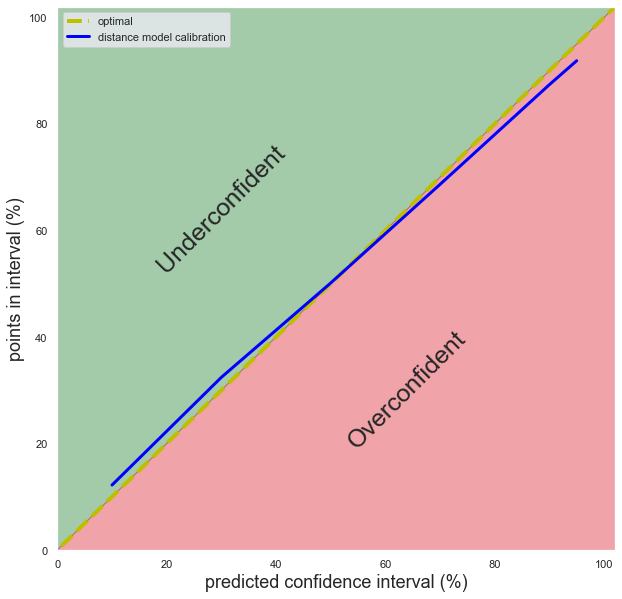

In [16]:
reg_plot.plot_calibration(macest_model, X_cal, y_cal)

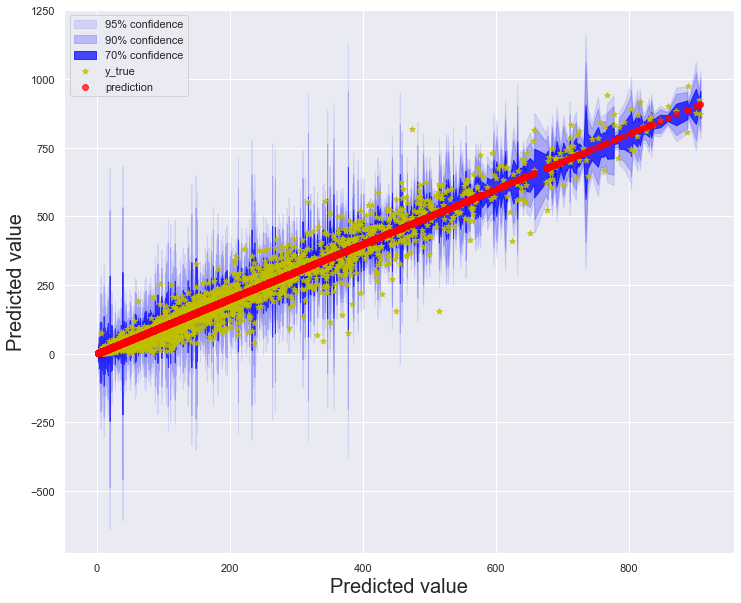

In [17]:
reg_plot.plot_predicted_vs_true(rf_bike, macest_model, X_cal, y_cal)

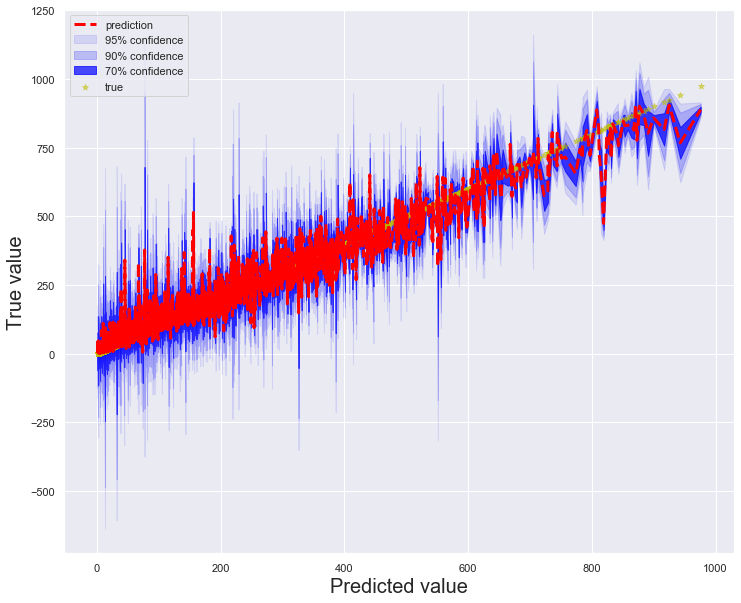

In [18]:
reg_plot.plot_true_vs_predicted(rf_bike, macest_model, X_cal, y_cal)

## Unseen 

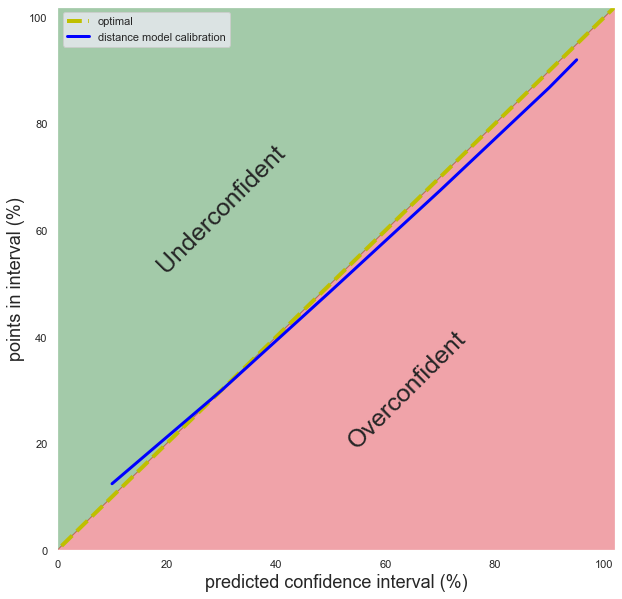

In [19]:
reg_plot.plot_calibration(macest_model, X_test, y_test)

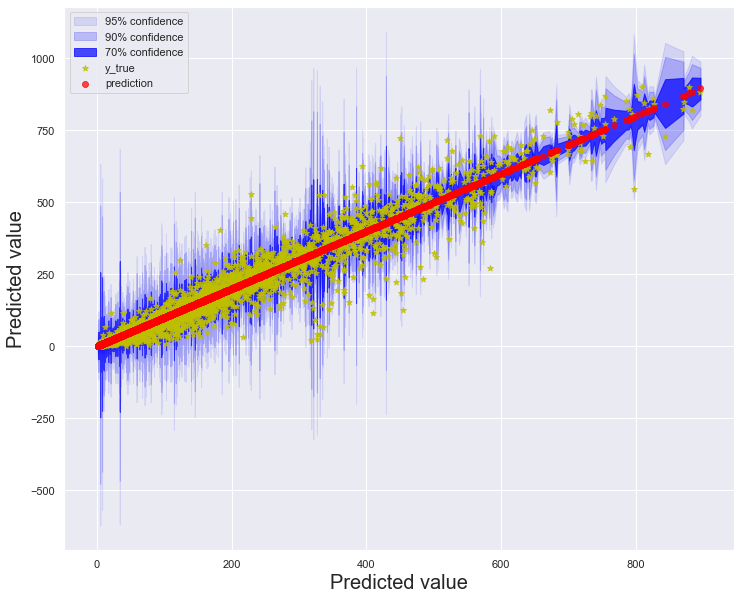

In [20]:
reg_plot.plot_predicted_vs_true(rf_bike, macest_model, X_test, y_test)

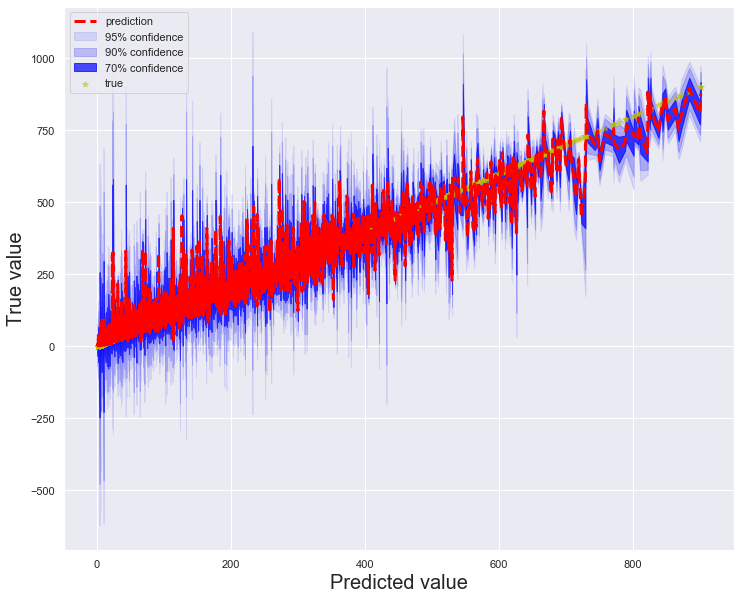

In [21]:
reg_plot.plot_true_vs_predicted(rf_bike, macest_model, X_test, y_test)